In [1]:
## imports

import numpy as np
import pandas as pd
import sklearn

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

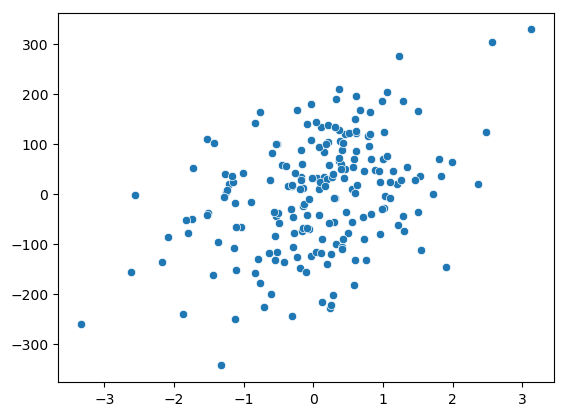

In [2]:
## toy dataset

from sklearn.datasets import make_regression

n = 200 ## number of samples

X, y = make_regression(n_samples=n, n_features=1, n_informative=1, n_targets=1, noise=100, random_state=27)

sns.scatterplot(x=X.flatten(), y=y)

In [3]:
## get ideal parameters for linear model using scikit-learn

from sklearn.linear_model import LinearRegression

reg = LinearRegression()

reg.fit(X, y)

ideal_slope, ideal_intercept = reg.coef_, reg.intercept_

print(f"ideal_slope: {round(ideal_slope[0],2)} ideal_intercept: {round(ideal_intercept,2)}")

ideal_slope: 45.66 ideal_intercept: -3.42


**Important**: Optimize for slope using minibatch stochastic gradient descent keeping intercept fixed at ideal value.

In [4]:
## define Root Mean Squared Error (RMSE) as loss function

def RMSE(m, c, x, y_true):
    
    y_pred = m*x.flatten() + c ## m-->slope, c-->intercept
    
    MSE = np.mean((y_true - y_pred)**2) ## MSE--> Mean Squared Error
    
    return np.sqrt(MSE)

In [5]:
## running minibatch gradient descent

m = float(np.random.randint(-1000, -900, 1)[0]) ## random slope initialization very far from ideal value

m_start = m ## to store initial value of m

c = ideal_intercept

batch_size = 20

iterations = n/batch_size

lr_initial = 1 ## huge initial learning rate

loss_list = list() ## list to store loss values over the epochs

m_list = list() ## list to store slope values over the loss

loss_slope = (-2/n)*np.sum(y - (m*X.flatten() + c))

Sdw = 0 ## for adaptive gradient descent, time-based exponentially moving average

beta = 0.95 ## for exponentially moving average, higher beta --> lesser increment in Sdw over time (check inside for loop)

while np.absolute(loss_slope) >= 0.01:
    
    epoch_loss = 0.
    
    for batch in range(int(iterations)):
        
        batch_indices = np.random.random_integers(0, len(X)-1, batch_size) ## stochastically (randomly) sampled
        
        X_batch = X[batch_indices]
        
        y_batch = y[batch_indices]
        
        loss_slope = (-2/batch_size)*np.sum(y_batch - (m*X_batch.flatten() + c)) ## new loss slope
        
        Sdw = beta*Sdw + (1-beta)*(loss_slope**2) ## updating exponentially weighted average
        
        lr = lr_initial/np.sqrt(Sdw + 1e-10) ## added extra small value to prevent zero denominator
        
        m = m - lr*loss_slope ## update gradient
        
        batch_loss = RMSE(m=m, c=c, x=X_batch, y_true=y_batch)
        
        epoch_loss += batch_loss
        
    epoch_loss = epoch_loss/iterations
    
    loss_list.append(epoch_loss)
    
    m_list.append(m)
    
print(f"m_initial: {m_start} | m_final:{m} | initial_learning_rate:{lr_initial} | final_learning_rate: {lr}")

C:\Users\abhin\anaconda3\envs\nlp_course\lib\site-packages\ipykernel_launcher.py:31: DeprecationWarning: This function is deprecated. Please call randint(0, 199 + 1) instead


m_initial: -933.0 | m_final:32.74463535483648 | initial_learning_rate:1 | final_learning_rate: 0.02333480795194544


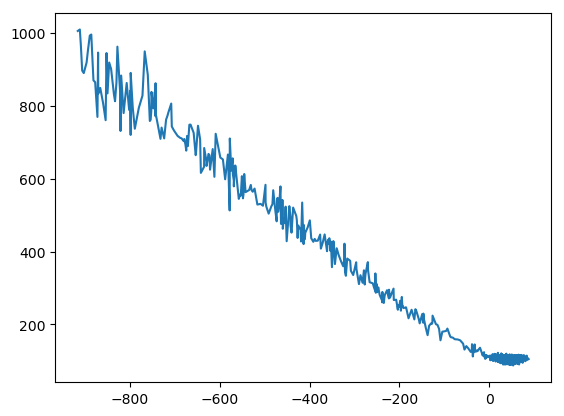

In [6]:
## plotting loss against values of slope

sns.lineplot(x=m_list, y=loss_list)

In [7]:
## checking total epochs

num_epochs = len(m_list)
num_epochs

4202

In [8]:
## checking final slope against ideal slope
print(f"final_slope: {round(m,2)}    ideal_slope: {round(ideal_slope[0],2)}")

final_slope: 32.74    ideal_slope: 45.66


In [9]:
## checking final loss against ideal loss
print(f"final_loss: {round(RMSE(m=m ,c=c, x=X, y_true=y),2)}    ideal_loss: {round(RMSE(m=ideal_slope ,c=c, x=X, y_true=y),2)}")

final_loss: 104.79    ideal_loss: 104.01


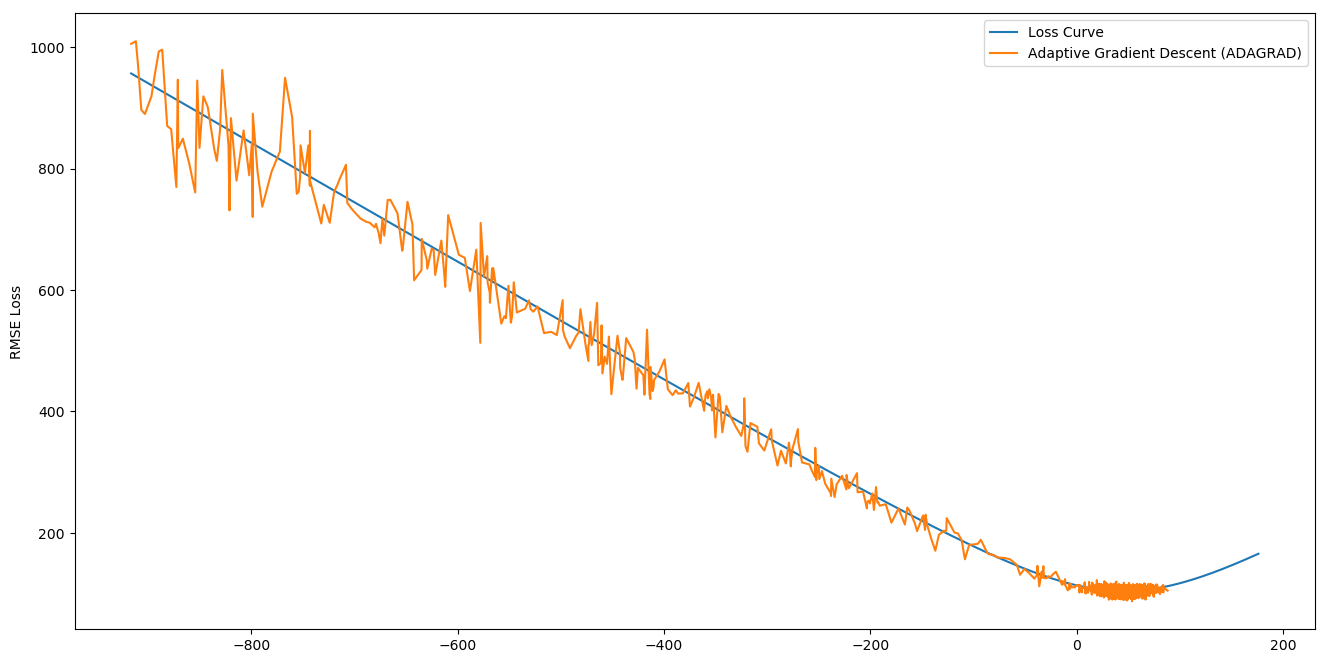

In [10]:
%matplotlib inline

plt, ax = plt.subplots(figsize=(16,8))

sns.lineplot(x=np.linspace(min(m_list), 2*max(m_list), num_epochs),
            y=[RMSE(m=m, c=c, x=X, y_true=y) for m in np.linspace(min(m_list), 2*max(m_list), num_epochs)],
            ax=ax)

sns.lineplot(x=m_list, y=loss_list, ax=ax)

ax.set_label('Slope (m)')

ax.set_ylabel('RMSE Loss')

ax.legend(['Loss Curve', 'Adaptive Gradient Descent (ADAGRAD)'])

**Important**: ADADELTA/RMSPROP prevents the learning rate from becoming so small that weight update gets difficult.